## Quantittive Detection performance assesment

In [1]:
import numpy as np
import pandas as pd
import SimpleITK as sitk
import seaborn as sns
import scipy.stats
from sklearn import metrics
import operator as op
import matplotlib.patches as mpatches
import os,re
import scipy
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
from scipy import ndimage
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
import itertools

from tqdm.notebook import tqdm 


In [2]:
## Load data
slice_labels_test = pd.read_excel('./data/detection_test_labels.xlsx')
slice_labels_val = pd.read_excel('./data/detection_val_labels.xlsx')


In [3]:
#define functions to plot accuracy score, conf. matrix, roc auc

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    
    return m, m-h, m+h

def calc_roc_auc(y_test,pred,n_bootstraps = 100,random_seed =42):
    
    y_test_distr = np.array(y_test.copy())
    y_pred_distr = np.array(pred.copy())

    random_gen = np.random.RandomState(random_seed)
    bootstrapped_scores = []


    for j in range(n_bootstraps):
        indices = random_gen.randint(0, len(y_pred_distr), len(y_pred_distr))
        if len(np.unique(y_test_distr[indices])) < 2:
            continue

        score = metrics.roc_auc_score(y_test_distr[indices], y_pred_distr[indices])
        bootstrapped_scores.append(score)
    
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    #CI95
    confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
    
    roc_auc=(metrics.roc_auc_score(y_test,pred))
    print('-'*40)
    print('ROC AUC: ',roc_auc,' 95% CI: ',confidence_lower,confidence_upper)
    print('-'*40)
    

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    Sensitivity = cm[1,1]/(cm[1,1]+cm[1,0])
    Specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    F1 = 2*cm[1,1] / (2*cm[1,1]+cm[0,1]+cm[1,0])
    print('Sensitivity is: ',Sensitivity)
    print('Specificity is: ',Specificity)
    print('F1 score is: ',F1)
    

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=16)#rotation=45,
    plt.yticks(tick_marks, classes,fontsize=16,rotation=90,verticalalignment="center")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=16)

    plt.ylabel('true label',fontsize=18)
    plt.xlabel('predicted label',fontsize=18)
    plt.tight_layout()
    return cm




## Test Set

Confusion matrix, without normalization
[[88  3]
 [ 4 91]]
Sensitivity is:  0.9578947368421052
Specificity is:  0.967032967032967
F1 score is:  0.9629629629629629
Normalized confusion matrix
[[0.97 0.03]
 [0.04 0.96]]
Sensitivity is:  0.9578947368421052
Specificity is:  0.967032967032967
F1 score is:  0.962291557724711


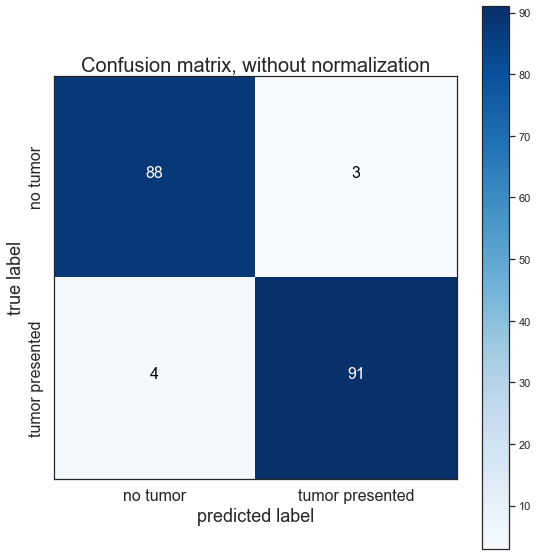

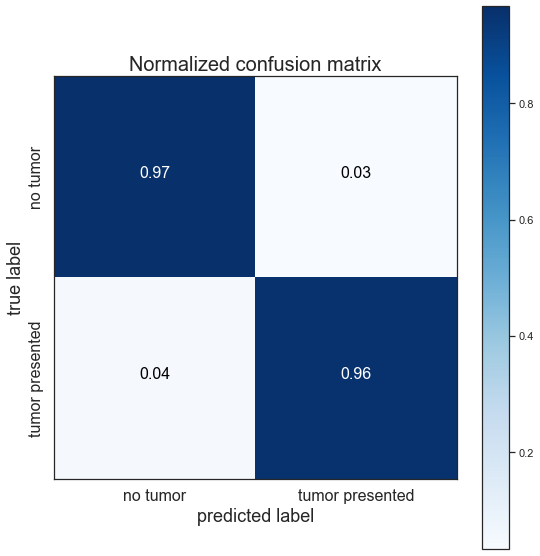

In [4]:
#display figures

gt_labels_test = slice_labels_test.ground_truth_labels
dl_labels_test = slice_labels_test.predicted_labels

class_names =['no tumor','tumor presented']    
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true = gt_labels_test,y_pred = dl_labels_test)
np.set_printoptions(precision=2)
sns.set(context='notebook',style='white')

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
non_cm = plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(8,8))
n_cm = plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')




In [5]:
calc_roc_auc(gt_labels_test,dl_labels_test)

----------------------------------------
ROC AUC:  0.9624638519375361  95% CI:  0.9409722222222222 0.9842105263157894
----------------------------------------


## Validation dataset

Confusion matrix, without normalization
[[191   2]
 [  9 270]]
Sensitivity is:  0.967741935483871
Specificity is:  0.9896373056994818
F1 score is:  0.9800362976406534
Normalized confusion matrix
[[0.99 0.01]
 [0.03 0.97]]
Sensitivity is:  0.967741935483871
Specificity is:  0.9896373056994818
F1 score is:  0.9784537389100126


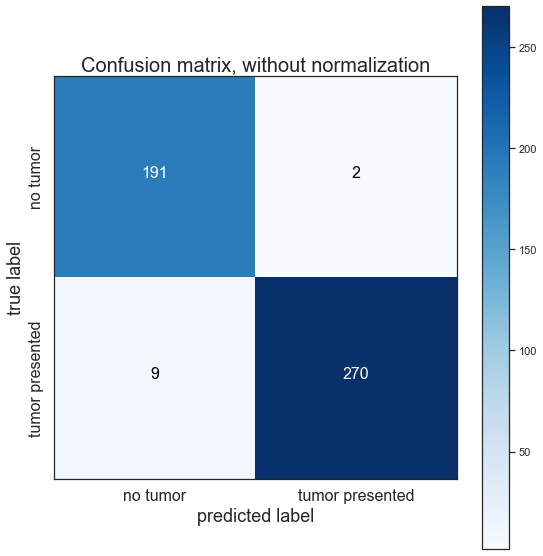

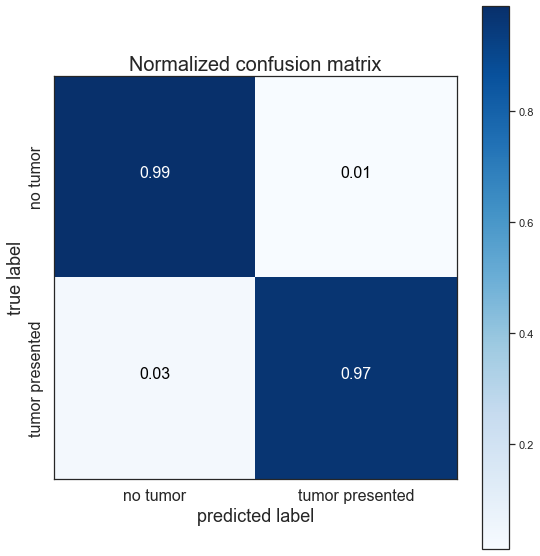

In [6]:
#display figures
gt_labels_val = slice_labels_val.ground_truth_labels
dl_labels_val = slice_labels_val.predicted_labels


class_names =['no tumor','tumor presented']    
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true = gt_labels_val,y_pred = dl_labels_val)
np.set_printoptions(precision=2)
sns.set(context='notebook',style='white')

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
non_cm = plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(8,8))
n_cm = plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')



In [7]:
calc_roc_auc(gt_labels_val,dl_labels_val)

----------------------------------------
ROC AUC:  0.9786896205916764  95% CI:  0.9675016479894527 0.9887253487253488
----------------------------------------
